<a href="https://colab.research.google.com/github/JpChii/ML-Projects/blob/main/Recurrent_Neural_Networks_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

Recurrent neural networks (RNN) are a class of neural networks that is powerful for modeling sequence data such as time series or natural language.
    
RNN's have a internal `for loop` to iterate over timestamps of sequence data. The RNN's have an internal state that encodes information about the timestamps it has seen.

Since `TesnorFlow` is my current primary framework for deep modelling, i'll use that in this blog.

The `Keras RNN API` provides us with `layers.RNN`, `layers.LSTM` and `layers.GRU` for ease of use. The` internal for loop` can be customized and used with `layers.RNN` for loop itself offering ease of customization.

In [ ]:
# Importing
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Built-in RNN layers

1. keras.layers.SimpleRNN
2. keras.layers.GRU
3. keras.layers.LSTM

They have many useful features, some of them are listed below,

* Recurrent dropout, via the `dropout` and `recurrent_dropout` arguments
* Process input sequence in reverse, via `go_backwords` argument
* Loop unrolling(can lead to large spedup when processig short sequences on CPU), via the unroll argument.

## Output and states
By default, output of a RNNlayer contains a single vector per sample. This vector is the RNN cell outut corresponding to the last timestamp, containing information about the entire sequence of inputs. The output shape will be `(batch_size,units)`, units is the number of units passed to RNN layer.

RNN layer can also return the entire sequence of output across the timestap(one vector per timestamp per sample). The output shape in this case will be `(batch_size, timesteps, units)`.

In [ ]:
# LEt's check out the above theory in a model
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000,output_dim=64))

# GRU with return sequence true
model.add(layers.GRU(256, return_sequences=True))

# SimpleRNN 
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In [ ]:
3 * (256 * (256+64+1) + 256)

247296

Calculating GRU's trainable parametes:

```
number of functional units * (hidden_units * (hidden_units + inputs + bias) + hidden units)
```

In the previous cell it's

```
3 * (64 * (64 + 128 + 1) + 64) = 37248
```

If we notice the number of trainable parameters has reduced in GRU compared to LSTM. Let's compare the metrics with baseline next.

In addition, RNN layer can return its final internal state(s). The returned states can be used to reusume the RNN execution later or to initialize another RNN. This setting is commonly used in the encoder-decoder sequence-to-sequene moel, where the encoder final state is used as the initial state of the decoder.

To configure a RNN layer to return it;s internal states, set `return_state` to `true` when creating the layer. `LSTM` has `2` states and `GRU` has `1` state.

And the encoder and decoder RNN layer must have the same number of units. And add `initial_state` to `internal state(s)` in decoding layer.

Let's write the code for this below.

In [ ]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab,
                                 output_dim=64)(encoder_input)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True)(encoder_embedded)

encoder_state = [state_h, state_c]

# Decoder
decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab,
                                    output_dim=64)(decoder_input)

# Pass the 2 states to a new decoder  layers
decoder_output = layers.LSTM(64)(decoder_embedded, initial_state=encoder_state)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input,decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
______________________________________________________________________________________________

## RNN layers and RNN cells

In addition to built-in RNN layers, there are also RNN cells provided by RNN API. Unlike RNN layers, cells can process only process a single timestamp.

`LSTM cell` wrapped in a `RNN layer` is equivalent to `LSTM layer`. But built-in `GRU` and `LSTM` layers enable the use of CuDNN and may see a better performance.

There are three built-in RNN cells, each of them corresponding to the matching RNN layer.

* `keras.layers.SimpleRNNCell` for `SimpleRNN` layer
* `keras.layers.GRUCell` for `GRU` layer
* `keras.layers.LSTMCell` for `LSTM`layer

This cell abdtraction, together with generic `RNN layer` makes it very easy to implement custom RNN architectures.

## Cross-batch statefulness

RNN's state is resetted when a new batch arrives in(i.e get's resetted for new sample), every sample seen by the layers is assumed to be independent of past.

If the sequences are long, possibly infinite. We can split the sequences and pass it to RNN without resetting the state using `stateful=True` parameter. This is called cross-batch statefulness.

In this splitted batches should be of the same size.

In [ ]:
# Implementaion of cross-batch statefulness
paragraph1 = np.random.random((20,10,50)).astype(np.float32)
paragraph2 = np.random.random((20,10,50)).astype(np.float32)
paragraph3 = np.random.random((20,10,50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)

In [ ]:
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)
                    
# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()

## RNN state reuse

RNN layer's recorded states can be accessed in `layers.states` and can be used as `initial_state` for another layer.

In [ ]:
#Getting recored state
existin_state = lstm_layer.states

# Initializing new layer with the above state
new_lstm_layer = layers.LSTM(64)
new_ouput = new_lstm_layer(paragraph3, initial_state=existin_state)

## Bidirectional RNNs

## Bidirectional RNNs

For sequences other than time series(eg text), it is often the case RNN mode performs better when processing the sequence forwards and backwards.

Read the text forward and sometimes reading it backwards gives beter understanding.

`keras.layers.bidirectional` wrapper can be used for this.

In [ ]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


Under the hood, Bidirectional will copy the RNN layer passed in, and flip the go_backwards field of the newly copied layer, so that it will process the inputs in reverse order.

The output of the Bidirectional RNN will be, by default, the concatenation of the forward layer output and the backward layer output. If you need a different merging behavior, e.g. concatenation, change the merge_mode parameter in the Bidirectional wrapper constructor. For more details about Bidirectional, please check the API docs

## Performance Optimization and cuDNN kernels

In TensorFlow 2.0 built-in LStm and GRU layers itself support CuDNN when GPU is available.

CuDNN kernel is built with certain assumptions, meaning layer won't be able to use Cudnn if the defaults of the built-in LSTM or GRU layers are changed.

[Constraints for LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM/)

[Constraints for GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/)

In [ ]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [ ]:
# Load MNIST dataset
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# Build and fit the model
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 9s 5ms/step - loss: 0.8934 - accuracy: 0.7147 - val_loss: 0.5061 - val_accuracy: 0.8374


In [ ]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 41s 42ms/step - loss: 0.3973 - accuracy: 0.8776 - val_loss: 0.8967 - val_accuracy: 0.7093


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8da050de-e853-2142-1ff0-71451742bd71)


Predicted result is: [3], target result is: 5


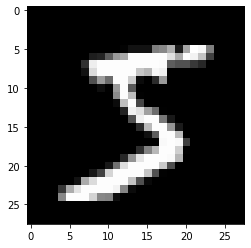

In [ ]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))